# Email Marketing Campaign

## Goal
Optimizing marketing campaigns is one of the most common data science tasks. Among the many marketing tools available, emails stand out as particularly efficient.
Emails are great because they are free, scalable, and can be easily personalized. Email optimization involves personalizing the content and/or the subject line, selecting the recipients, and determining the timing of the sends, among other factors. Machine Learning excels at this.


## Case Description
The marketing team of an e-commerce site has launched an email campaign. This site has email addresses from all the users who created an account in the past.
They have chosen a random sample of users and emailed them. The email lets the user know about a new feature implemented on the site. From the marketing team perspective, success is if the user clicks on the link inside of the email. This link takes the user to the company site.
You are in charge of figuring out how the email campaign performed and were asked the following questions:
1. What percentage of users opened the email and what percentage clicked on the link within the email?
2. The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?
3. By how much do you think your model would improve click through rate (defined as # of users who click on the link/total users who receive the email). How would you test that?
4. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.


## 1. Imports and Setup

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
%matplotlib inline

## 2. Load the Data

In [2]:
# Load and inspect the data
email_table = pd.read_csv('email/email_table.csv')
email_opened_table = pd.read_csv('email/email_opened_table.csv')
link_clicked_table = pd.read_csv('email/link_clicked_table.csv')

 ## 3. Explore the Data

In [3]:
# Display basic info about email_table
email_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
# Display basic info about email_opened_table
email_opened_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [5]:
# Display basic info about link_clicked_table
link_clicked_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


In [6]:
# Display the head (first few rows) in email_table
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [7]:
# display the head (first few rows) in email_opened_table
email_opened_table.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [8]:
# display the head (first few rows) in link_clicked_table
link_clicked_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


### Q. What percentage of users opened the email and what percentage clicked on the link within the email?

## 4. Calculate Open and Click Rates

In [9]:
# Step 1: Total number of emails sent
total_emails_sent = float(email_table.shape[0])
print(f"Total emails sent: {total_emails_sent}")

Total emails sent: 100000.0


In [10]:
# Step 2: Number of emails opened
opened_emails = email_table[email_table.email_id.isin(email_opened_table.email_id)].shape[0]
print(f"Emails opened: {opened_emails}")

Emails opened: 10345


In [11]:
# Step 3: Percentage of emails opened
percent_opened = (opened_emails / total_emails_sent) * 100
print("Percent of users who opened the email: {:.2f}%".format(percent_opened))

Percent of users who opened the email: 10.35%


In [12]:
# Step 4: Number of emails where link was clicked
clicked_emails = email_table[email_table.email_id.isin(link_clicked_table.email_id)].shape[0]
print(f"Emails with link clicked: {clicked_emails}")

Emails with link clicked: 2119


In [13]:
# Step 5: Percentage of emails clicked
percent_clicked = (clicked_emails / total_emails_sent) * 100
print("Percent of users who clicked the link in the email: {:.2f}%".format(percent_clicked))

Percent of users who clicked the link in the email: 2.12%


A. The marketing team sent an email campaign intended to notify users of a new feature on the e-commerce website. To measure its success, we tracked the number of users who engaged with the email. 10.35% of the total users who were sent the email opened it, reflecting a moderate degree of interest or curiosity in the subject line and sender details. Nonetheless, the fact that just 2.12% of those who opened the email proceeded to click the link within it was the major aim of the campaign. That click-through rate is an indicator of how much interest the content and call-to-action of the email were able to generate. Generally, though a number of users indicated some level of interest by opening the email, an insignificant fraction went ahead to make the intended action of accessing the site through the link provided.

### Q. The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

## 5. Remove Outliers (for Modeling)

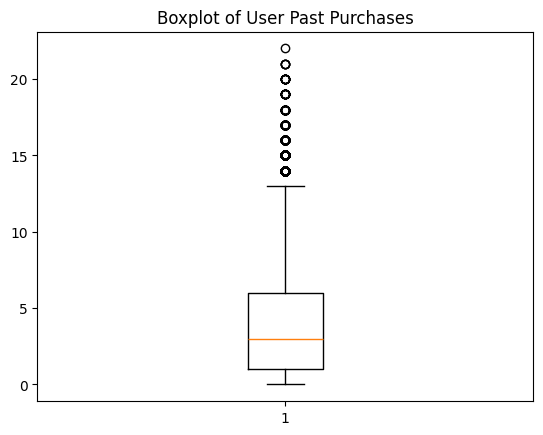

In [14]:
# Check for outliers in user purchases
plt.boxplot(email_table.user_past_purchases)
plt.title("Boxplot of User Past Purchases")
plt.show()

In [15]:
# Filter out high outliers (example threshold: < 12)
non_outliers = email_table[email_table.user_past_purchases < 12]

## 6. Add Target Column

In [16]:
# Add a 'link_clicked' column to the dataframe (target variable)
clicked_emails = set(link_clicked_table.email_id)
non_outliers['link_clicked'] = non_outliers['email_id'].isin(link_clicked_table['email_id']).astype(int)

In [17]:
# Display the head (first few rows) in non_outliers
non_outliers.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,link_clicked
0,85120,short_email,personalized,2,Sunday,US,5,0
1,966622,long_email,personalized,12,Sunday,UK,2,1
2,777221,long_email,personalized,11,Wednesday,US,2,0
3,493711,short_email,generic,6,Monday,UK,1,0
4,106887,long_email,generic,14,Monday,US,6,0


In [18]:
# percentage of users from each country
non_outliers.user_country.value_counts(normalize=True)

user_country
US    0.600942
UK    0.199662
FR    0.099754
ES    0.099642
Name: proportion, dtype: float64

In [19]:
# Over 90% of the user base is in the US and UK. For now, we'll simplify the problem and focus only on users in the US and UK.
us_uk_emails = non_outliers[non_outliers.user_country.isin(['US','UK'])]

In [20]:
# Create a binary column 'country_US' to indiciate if the user is in the US or UK
us_uk_emails['country_US'] = us_uk_emails.user_country.apply((lambda x: 1 if x == 'US' else 0))

In [21]:
# Create a binary column for the email text. Value is 1 for short_emails, 0 for long emails
us_uk_emails['is_short'] = us_uk_emails.email_text.apply((lambda x: 1 if x == 'short_email' else 0))

In [22]:
# Create a binary column for email version. Value is 1 for generic emails, 0 for personalized emails
us_uk_emails['is_generic'] = us_uk_emails.email_version.apply((lambda x: 1 if x == 'generic' else 0))

In [23]:
# the percentage of users who clicked the link for emails sent during each hour of the day.
us_uk_emails[us_uk_emails['link_clicked'] == 1].hour.value_counts(normalize=True)

hour
10    0.107761
9     0.105528
11    0.095477
12    0.078169
8     0.077052
7     0.068677
6     0.060302
5     0.054160
13    0.053043
14    0.044668
15    0.044109
4     0.041318
3     0.040759
16    0.030709
2     0.028476
1     0.024567
17    0.017309
18    0.010609
19    0.006700
23    0.003350
20    0.003350
21    0.001675
22    0.001675
24    0.000558
Name: proportion, dtype: float64

In [24]:
# Very few people who click on the email links do so during the evening hours. We'll therefore lump these variables into a
# a category called EVENING to reduce the number of dummy variables to create for the model.
evening_hours = [19,20,21,22,23,24]
us_uk_emails['hour_sent'] = us_uk_emails.hour.apply((lambda x: 'EVENING' if x in evening_hours else str(x)))

In [25]:
# Create dummy variables for the weekday and hour columns
weekday_dummies = pd.get_dummies(us_uk_emails.weekday,prefix='weekday').drop('weekday_Sunday',axis=1)
hour_dummies = pd.get_dummies(us_uk_emails.hour_sent,prefix='hour_sent').drop('hour_sent_EVENING',axis=1)

## 7. Feature Engineering

In [26]:
# Create the feature matrix
df = us_uk_emails[['user_past_purchases','is_short','is_generic','link_clicked']]
df = df.join(weekday_dummies)
df = df.join(hour_dummies)
y = df.pop('link_clicked').values
X = df.values

In [27]:
'''
Since a very tiny percentage of users who clicked the link in the email, we will undersample the majority class to balance
the dataset.
'''
def undersample(X,y):
    majority_X = X[y == 0]
    majority_y = y[y == 0]
    minority_y = y[y == 1]
    minority_X = X[y == 1]
    minority_size = y[y == 1].shape[0]
    
    inds = np.arange(minority_size)
    samples = np.random.choice(inds, minority_size,replace=False)
    
    undersampled_X = np.concatenate((majority_X[samples],minority_X), axis=0)
    undersampled_y = np.concatenate((majority_y[samples],minority_y), axis=0)
    return (undersampled_X, undersampled_y)

## 8. Split the Data

In [28]:
# Split the data into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

In [29]:
# Undersample the training data to balance the classes
X_sub,y_sub = undersample(X_train,y_train)

## 9. Train and Test the Multiple Models

### Train and tune a random forest classifer 

In [30]:
# Define hyperparameter grid
rf_params = {'n_estimators':[20,30,40,50],
             'criterion':['gini','entropy'],
             'max_features':['sqrt','log2'],
             'min_samples_leaf':[1,2,5,10,11,12,13,14,15],
             'min_samples_split':[2, 3, 5, 7,10]}

In [31]:
# Initialize GridSearchCV
rf_clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='roc_auc',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # run in parallel (faster)
    verbose=1
)

In [32]:
# Fit model
rf_clf.fit(X_sub, y_sub)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 11, 12, 13, 14, 15],
                         'min_samples_split': [2, 3, 5, 7, 10],
                         'n_estimators': [20, 30, 40, 50]},
             scoring='roc_auc', verbose=1)

In [33]:
# Print the best parameters
print("Best Parameters:", rf_clf.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 2, 'n_estimators': 30}


In [34]:
# print the Best ROC AUC Score
print("Best ROC AUC Score:", rf_clf.best_score_)

Best ROC AUC Score: 0.7071227391183188


### Test the random forest classifer 

In [35]:
# Test random forest model on the validation set
rf = RandomForestClassifier(criterion = 'entropy',
                            max_features = 'sqrt',
                            min_samples_leaf = 12,
                            min_samples_split = 7,
                            n_estimators= 40)
rf.fit(X_sub,y_sub)
rf_pred = rf.predict(X_val)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val, rf_pred)
rf_recall = recall_score(y_val, rf_pred)
rf_auc = auc(rf_fpr, rf_tpr)

In [36]:
# print the AUC and Recall results
print("Random Forest (AUC, Recall): {0}".format((rf_auc,rf_recall)))

Random Forest (AUC, Recall): (0.6515244064281644, 0.7189189189189189)


### Train and tune a logistic regression classifer 

In [37]:
lr_params = {'C':[0.1,0.2, 0.3, 0.4]}
lr_clf = GridSearchCV(LogisticRegression(),lr_params,scoring='roc_auc')
lr_clf.fit(X_sub,y_sub)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4]}, scoring='roc_auc')

In [38]:
print("Best Parameters:", lr_clf.best_params_)

Best Parameters: {'C': 0.1}


In [39]:
print("Best ROC AUC Score:", lr_clf.best_score_)

Best ROC AUC Score: 0.7055402658569063


### Test the logisitic regression classifer 

In [40]:
# Test Logistic regression model on the validation set
lr = LogisticRegression(C=0.1)
lr.fit(X_sub,y_sub)
lr_pred = lr.predict(X_val)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_val, lr_pred)
lr_recall = recall_score(y_val, lr_pred)
lr_auc = auc(lr_fpr, lr_tpr)

In [41]:
# print the AUC and Recall results
print("Logistic Regression (AUC, Recall) {0}".format((lr_auc,lr_recall)))

Logistic Regression (AUC, Recall) (0.6766672918826907, 0.6810810810810811)


### Train and tune a XG Boost classifer 

In [42]:
xgb_params = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

In [43]:
xgb_clf = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [44]:
xgb_clf.fit(X_sub, y_sub)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [45]:
# Print the best parameters
print("Best Parameters:", xgb_clf.best_params_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [46]:
# print the Best ROC AUC Score
print("Best AUC Score:", xgb_clf.best_score_)

Best AUC Score: 0.7085078929866968


In [48]:
# Test XG Boost model on the validation set
xgb = XGBClassifier(use_label_encoder= False, eval_metric= 'logloss', learning_rate=0.1, n_estimators=100, max_depth=3)
xgb.fit(X_sub, y_sub)
xgb_pred = xgb.predict(X_val)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_pred)
xgb_recall = recall_score(y_val, xgb_pred)
xgb_auc = auc(xgb_fpr, xgb_tpr)

In [50]:
# print the AUC and Recall results 
print("XG Boost (AUC, Recall) {0}".format((xgb_auc,xgb_recall)))

XG Boost (AUC, Recall) (0.664506014460185, 0.7243243243243244)


In [51]:
# THe Random Forest classifer appears to be the best. Let's check out it's confusion matrix.
confusion_matrix(y_val,rf_pred)

array([[4461, 3176],
       [  52,  133]], dtype=int64)

### Q. By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

A. I would anticipate a minimum 1% increase in click-through rate (CTR), which is the number of users who click on the link over the total number of users who were sent the email. To determine if this is the case, I would run an A/B test.

This is how I'd design it:

Split the users randomly into two groups:

Control Group: Sent emails using the current random targeting strategy.

Test Group: Receives emails targeted using the machine learning model — we’d select top-N users predicted to have the highest probability of clicking.

Launch a parallel email campaign for both groups, keeping everything else constant (email content, timing, etc.).

Measure the CTR in both groups at the end of the campaign.

Perform a statistical test (e.g., two-proportion z-test) to see whether the difference in CTR observed is statistically significant and not by chance.

### Q. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

AI noticed that the ideal times for users who click on the link in the email vary by country and by day of the week. See the bar plots below.

In [52]:
def plot_hourly_counts(ax, df, atitle):
    email_hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    email_counts = df.groupby(['hour','link_clicked'])['email_id'].count().to_dict()

    counts_clicked = []
    counts_noclicked = []
    bar_width = 0.35
    ind = np.arange(len(email_hours))

    for e in email_hours:
        if (e,1) in email_counts:
            counts_clicked.append(email_counts[(e,1)])
        else:
            counts_clicked.append(0)
        if (e,0) in email_counts:
            counts_noclicked.append(email_counts[(e,0)])
        else:
            counts_noclicked.append(0)
    ax.bar(ind,counts_clicked,bar_width,color='r',label='clicked')
    ax.bar(ind+bar_width,counts_noclicked,bar_width,color='g',label='not clicked')
    ax.set_title(atitle)

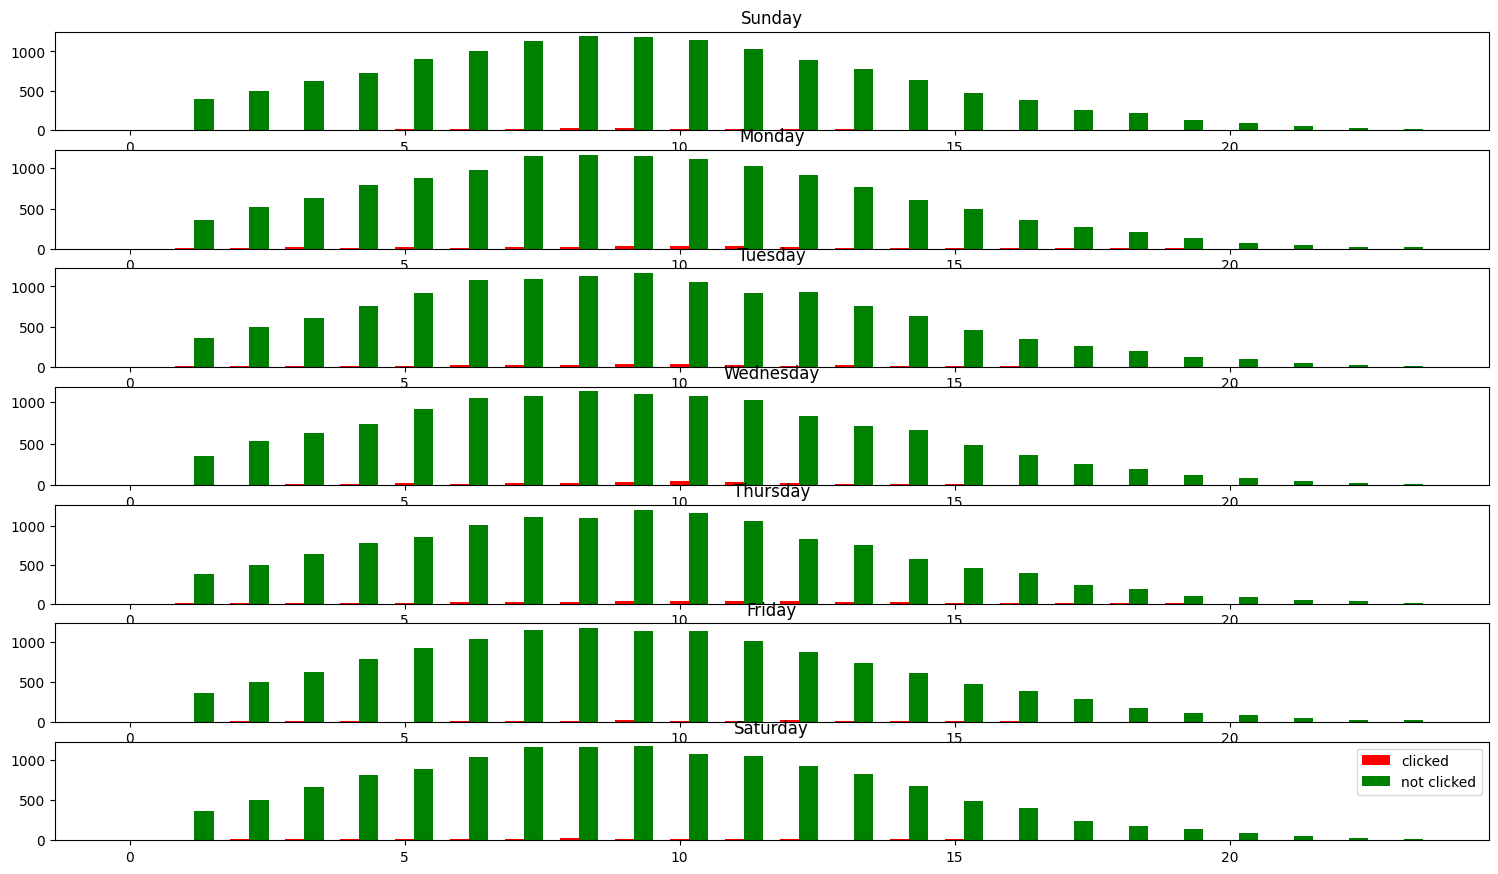

In [53]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
for i in range(7):
    df = non_outliers[non_outliers.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

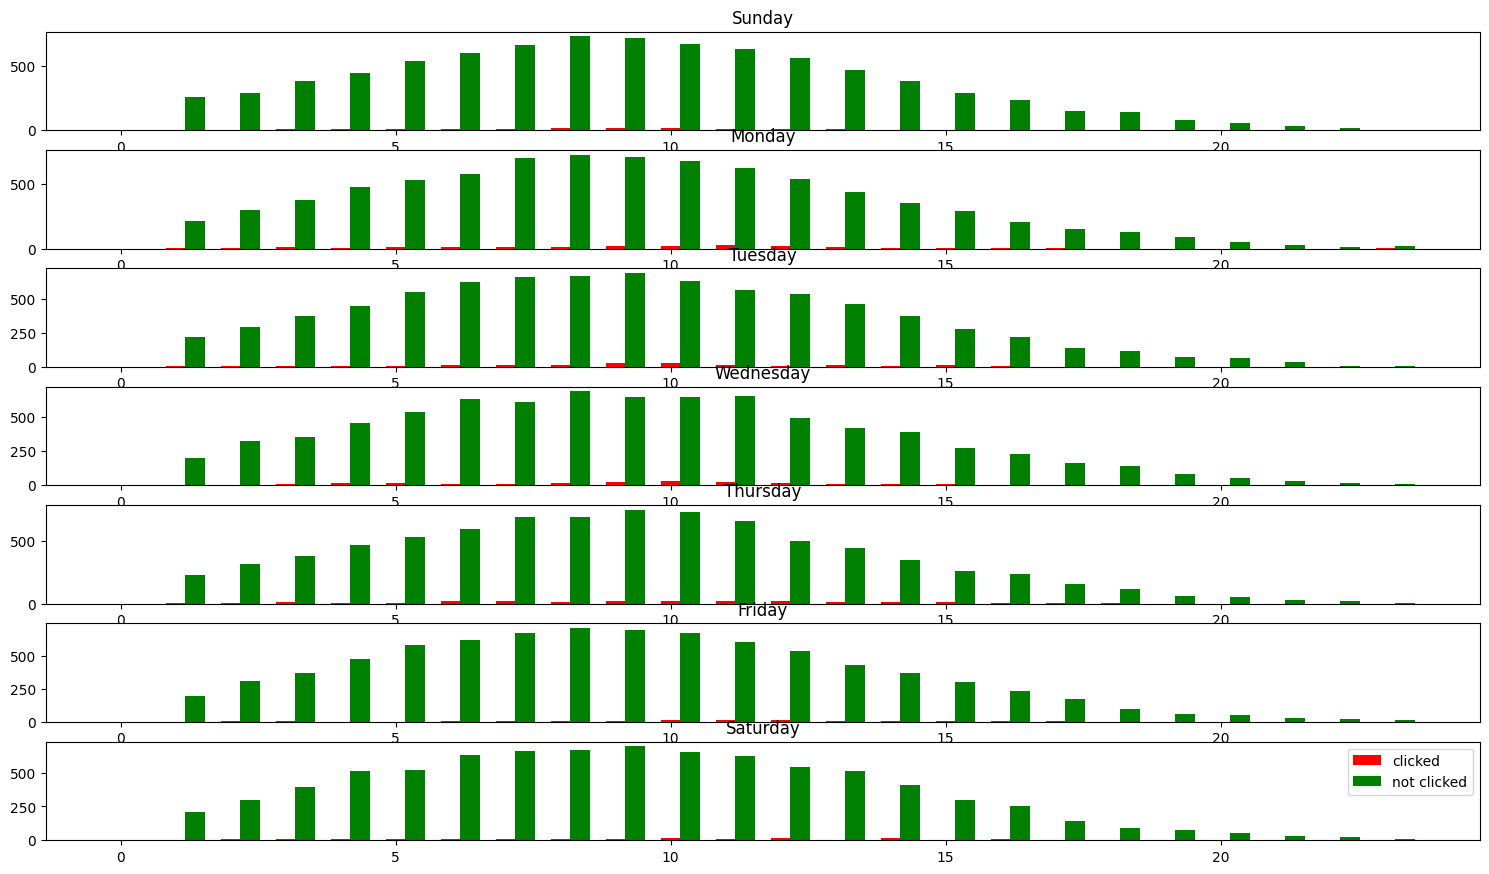

In [54]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'US']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

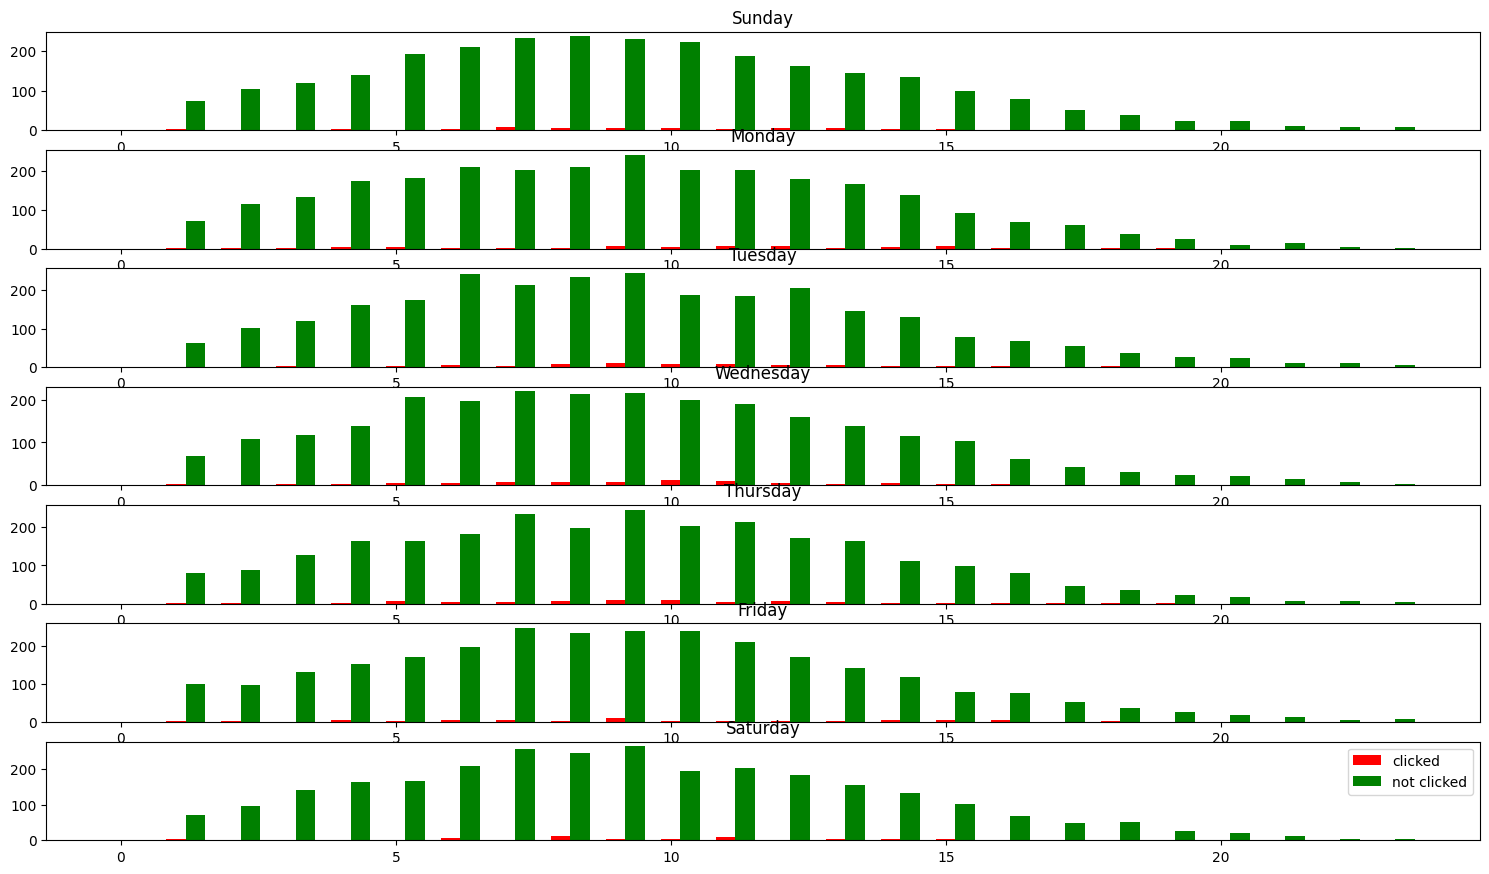

In [55]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'UK']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

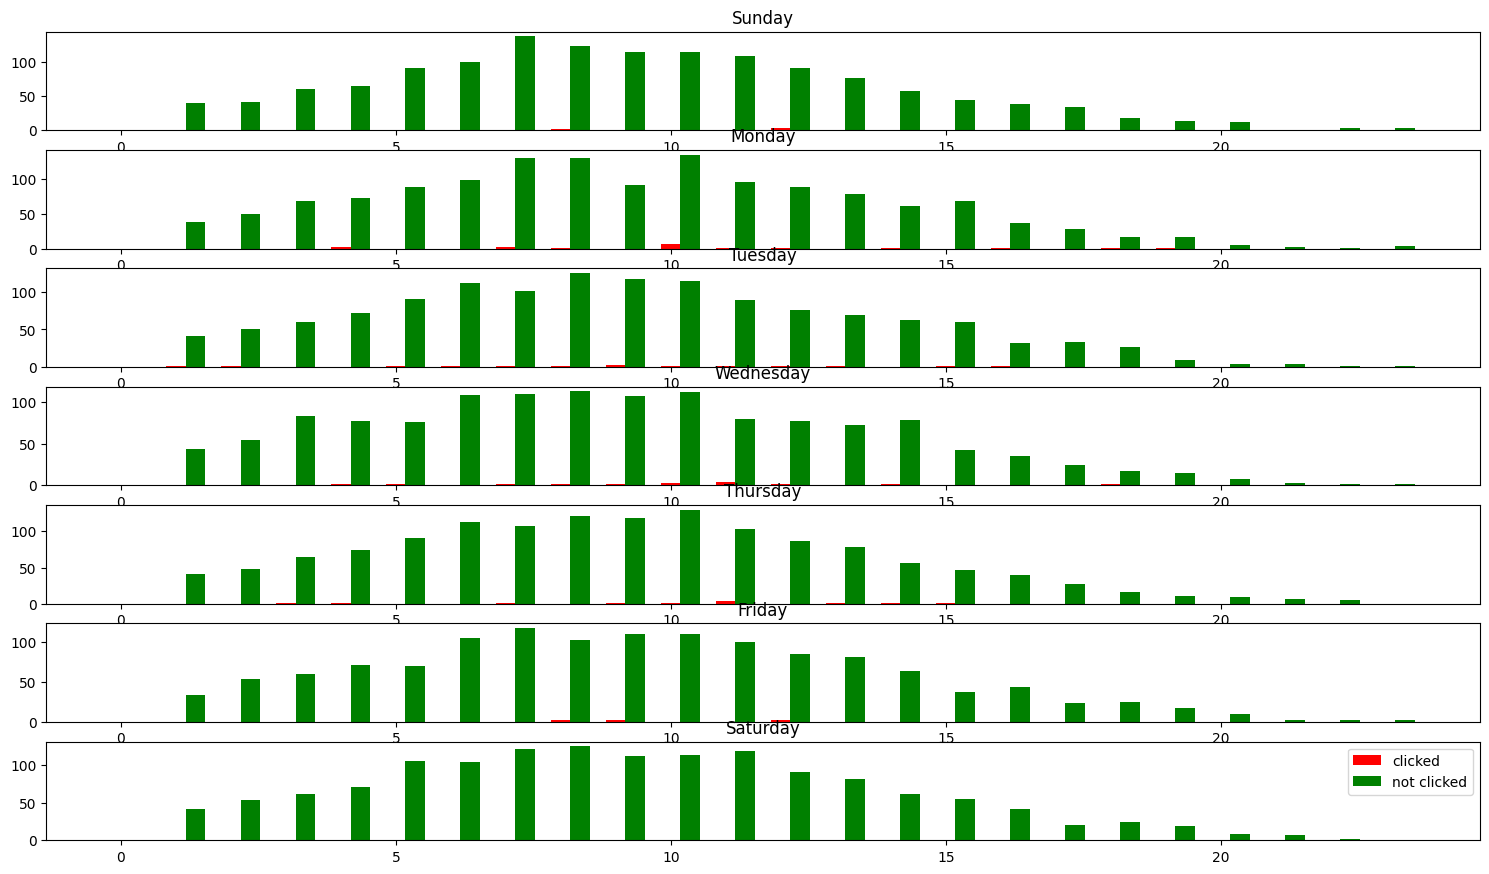

In [56]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'ES']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()

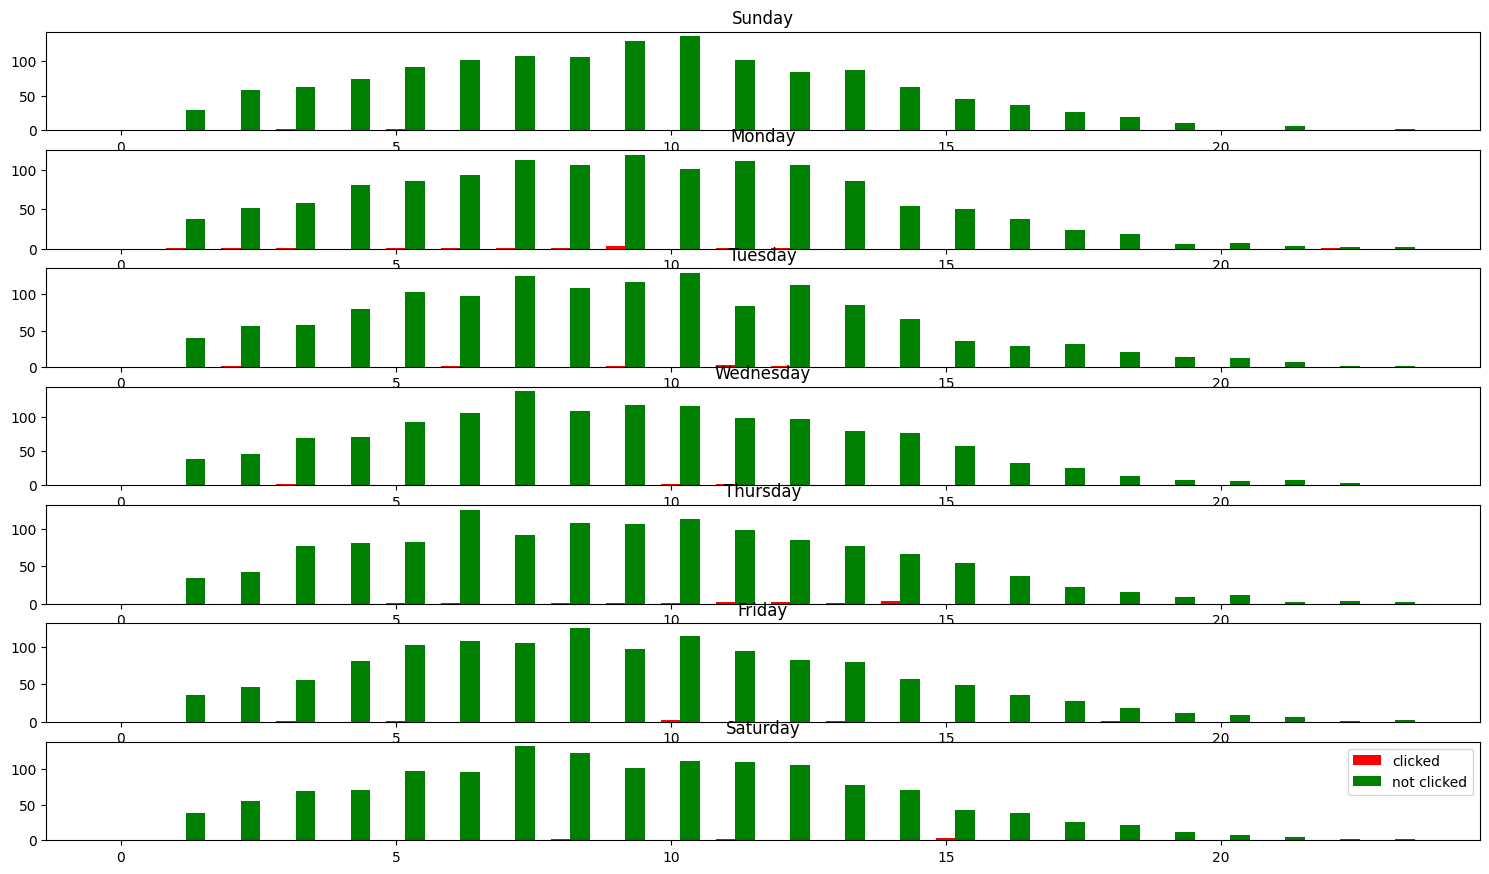

In [57]:
fig, axes = plt.subplots(7,1)
fig.set_size_inches(18.5, 10.5)
dow = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
pos = 0
us_emails = non_outliers[non_outliers.user_country == 'FR']
for i in range(7):
    df = us_emails[us_emails.weekday ==  dow[pos]]
    plot_hourly_counts(axes[i], df, dow[pos])
    pos += 1
plt.legend()